In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
from skimage.transform import resize

C:\Users\sweth\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

In [3]:
# ml libs
import keras
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [4]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

(0.0, 1.0, 0.0, 1.0)

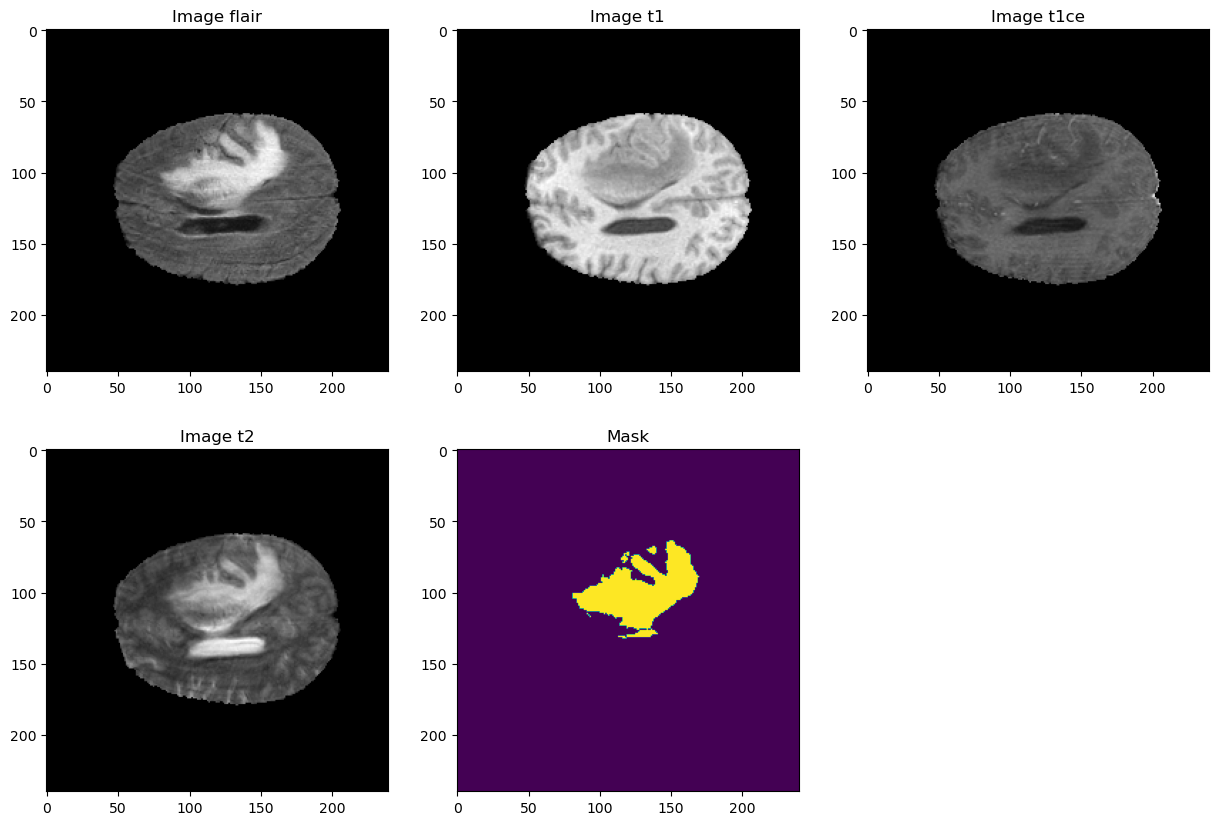

In [5]:
TRAIN_DATASET_PATH = 'bratstv/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
# VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')
ax6.axis('off')

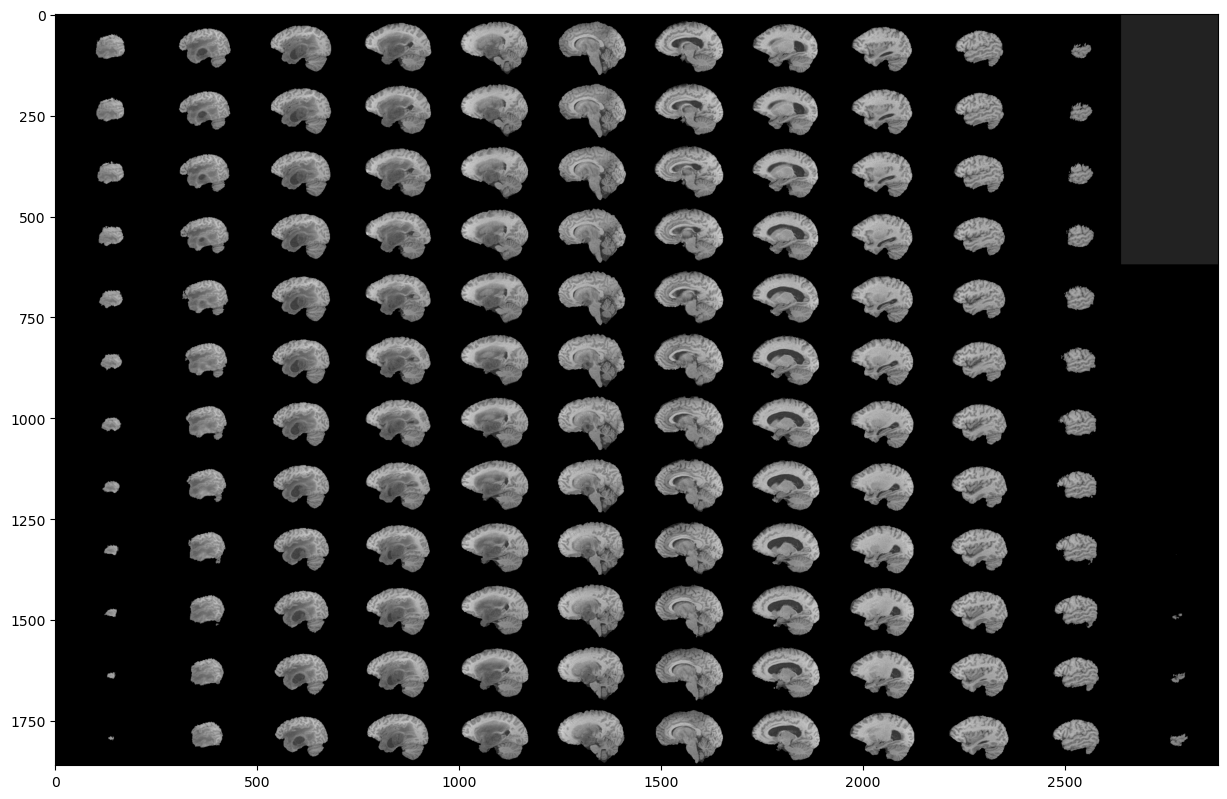

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

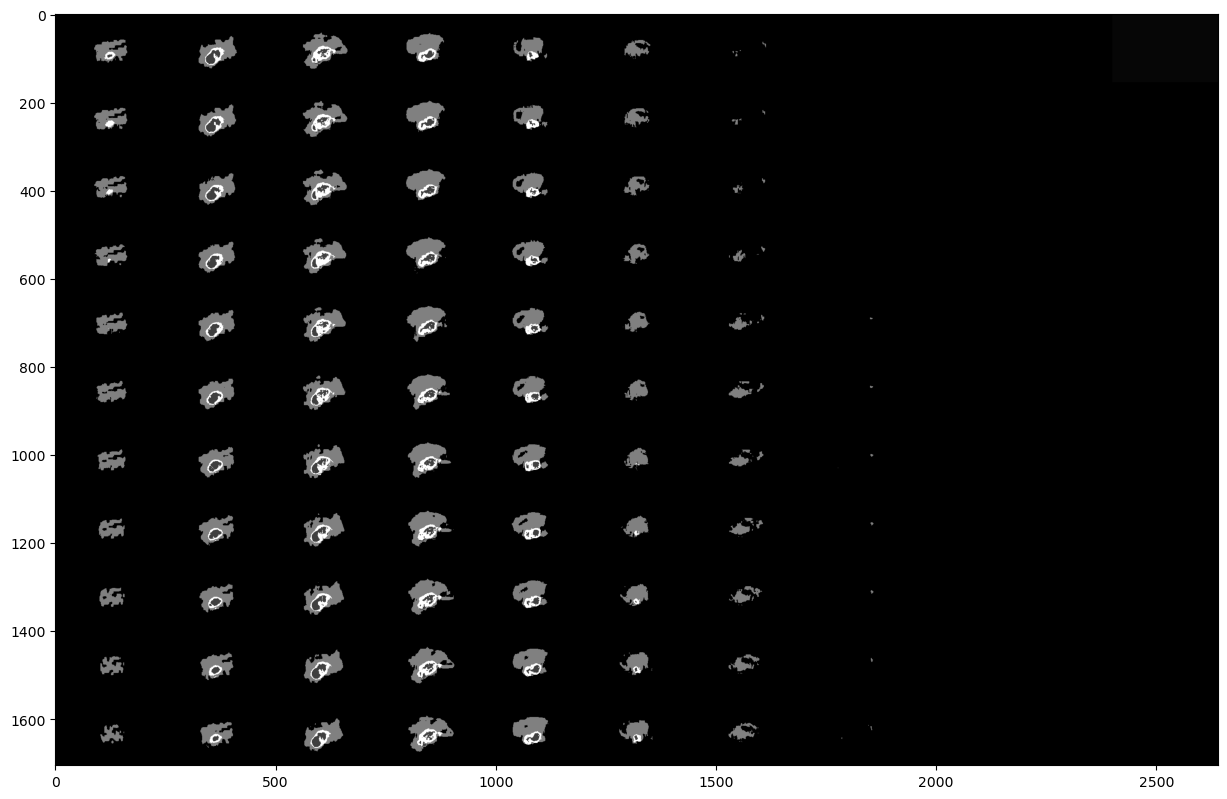

In [7]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [8]:
#Metrics

# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [9]:
IMG_SIZE = 128

In [10]:
#U-Net Model
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [11]:
plot_model(model, show_layer_names = True, dpi = 70)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]



def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

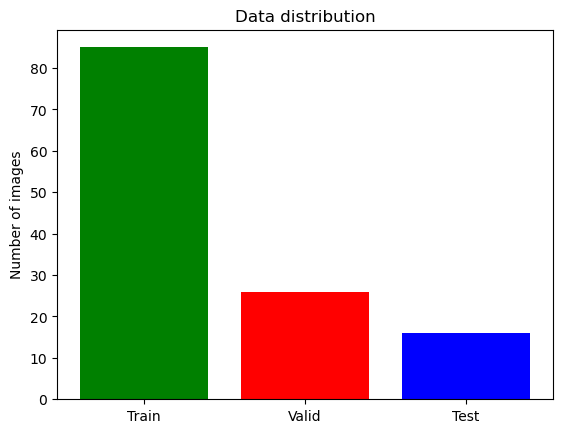

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [15]:
csv_logger = CSVLogger('training_per_class.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [16]:
# K.clear_session()
# 
# history =  model.fit(training_generator,
#                     epochs=35,
#                      steps_per_epoch=len(train_ids),
#                      callbacks= callbacks,
#                      validation_data = valid_generator
#                      )  

# model.save('model_per_class.h5')

In [17]:
#load model
model = keras.models.load_model('model_per_class.h5', compile=False)

# history = pd.read_csv('/kaggle/input/model_per_class/tensorflow2/default/1/training_per_class.log', sep=',', engine='python')

# hist=history


# acc=hist['accuracy']
# val_acc=hist['val_accuracy']

# epoch=range(len(acc))

# loss=hist['loss']
# val_loss=hist['val_loss']

# train_dice=hist['dice_coef']
# val_dice=hist['val_dice_coef']

# f,ax=plt.subplots(1,2,figsize=(16,8))

# ax[0].plot(epoch,acc,'b',label='Training Accuracy')
# ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
# ax[0].legend()

# ax[1].plot(epoch,loss,'b',label='Training Loss')
# ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
# ax[1].legend()

# plt.show()

In [18]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step


<Figure size 1800x5000 with 0 Axes>

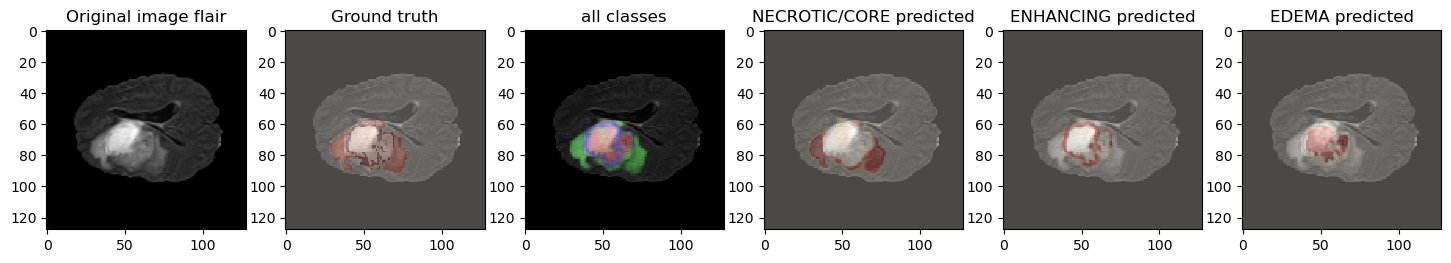

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


<Figure size 1800x5000 with 0 Axes>

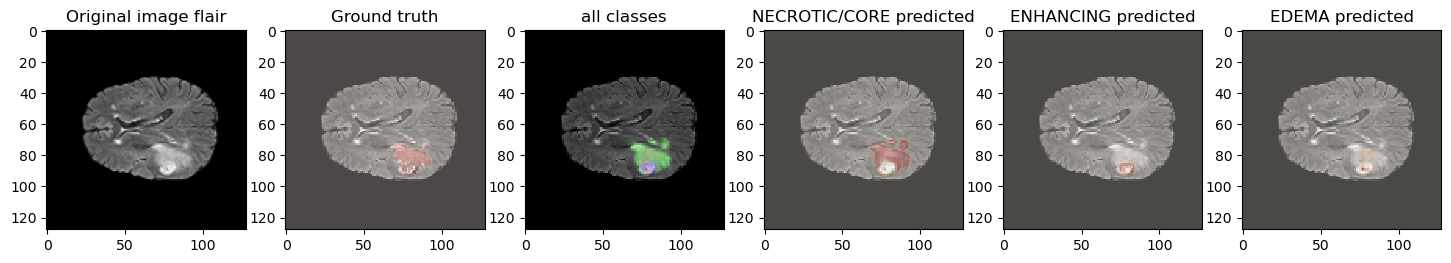

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


<Figure size 1800x5000 with 0 Axes>

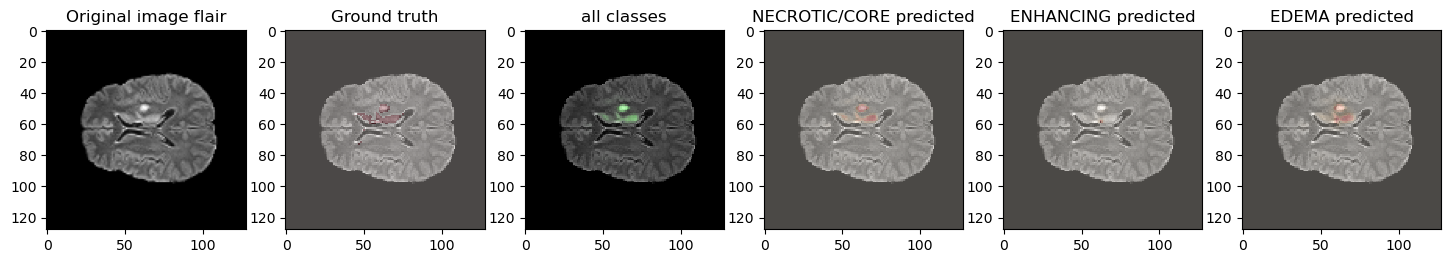

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

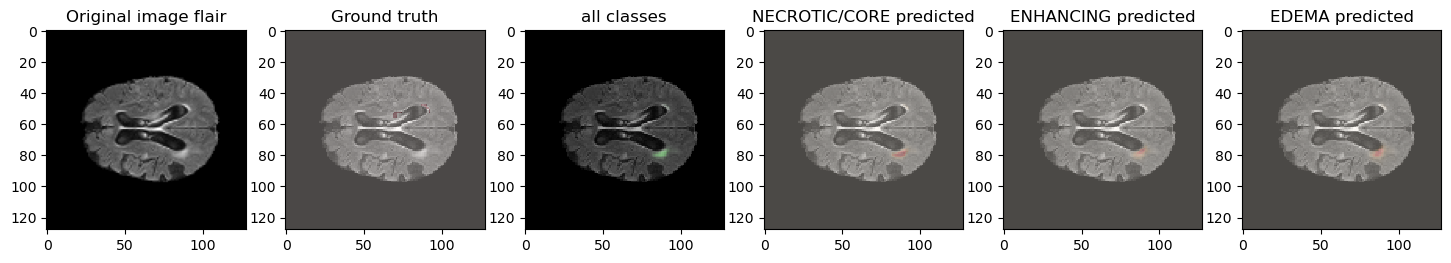

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


<Figure size 1800x5000 with 0 Axes>

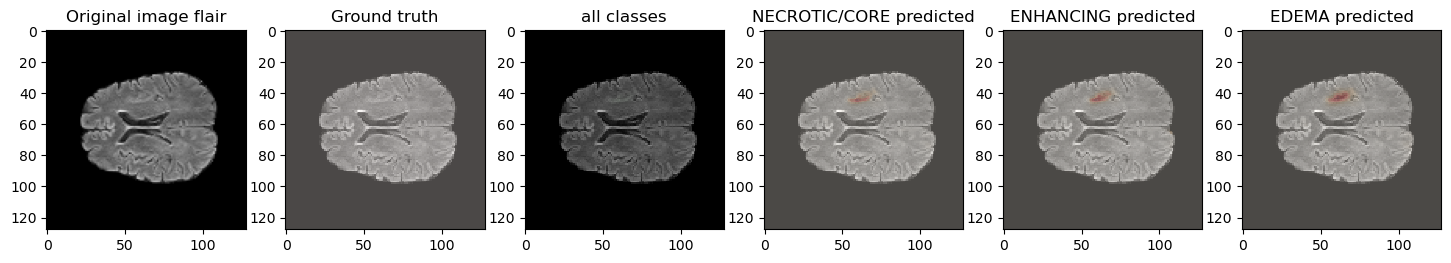

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


<Figure size 1800x5000 with 0 Axes>

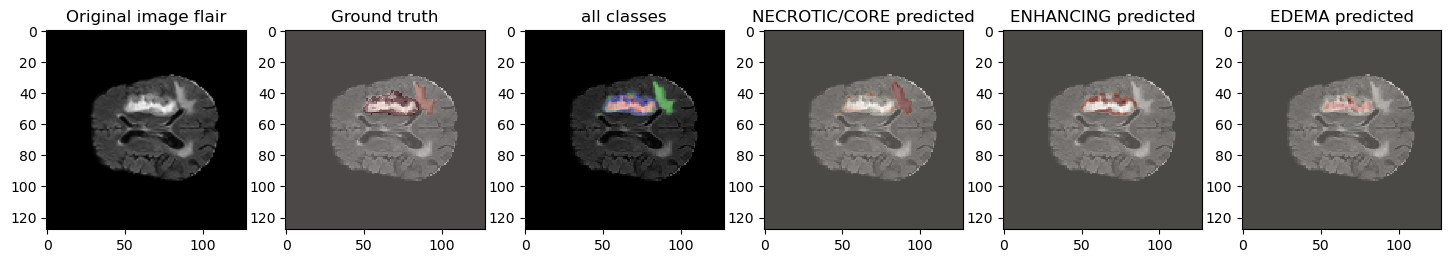

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step


<Figure size 1800x5000 with 0 Axes>

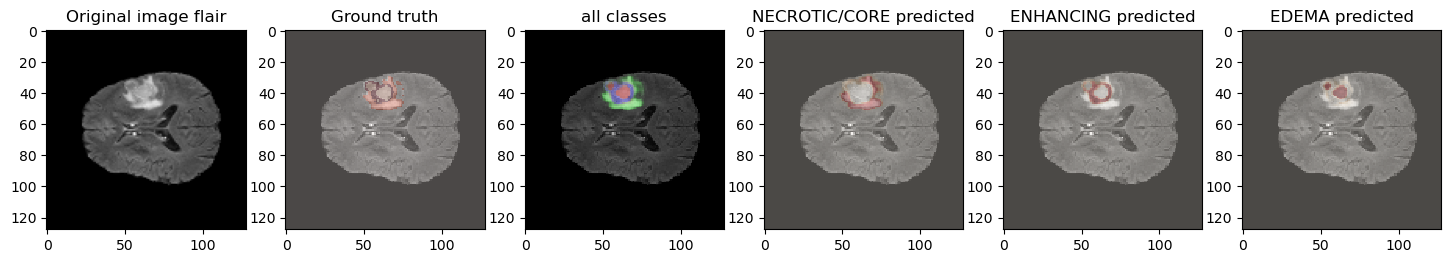

In [19]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"bratstv/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    axarr[5].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step


<Figure size 640x480 with 0 Axes>

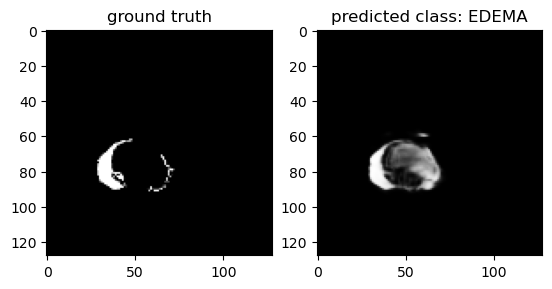

In [25]:
case = test_ids[0][-3:]
path = f"bratstv/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [29]:
import plotly.graph_objects as go
import numpy as np
from skimage import measure
from scipy.ndimage import zoom
from tqdm.notebook import tqdm
import plotly.io as pio

def create_3d_visualization(orig_volume, pred_volume, threshold=0.5, scale_factor=0.5):
    """
    Create enhanced 3D visualization of brain and tumor with improved visibility
    """
    print("Preprocessing volumes...")
    
    # Downsample volumes for better performance
    orig_volume = zoom(orig_volume, scale_factor)
    pred_volume = zoom(pred_volume, [scale_factor, scale_factor, scale_factor, 1])
    
    # Normalize volumes
    orig_volume = orig_volume / np.max(orig_volume)
    
    print("Creating brain surface...")
    # Create brain surface with lower threshold for better context
    verts_brain, faces_brain, _, _ = measure.marching_cubes(orig_volume, level=0.15)
    
    # Create figure
    fig = go.Figure()
    
    # Add brain surface with very low opacity
    fig.add_trace(go.Mesh3d(
        x=verts_brain[:, 0],
        y=verts_brain[:, 1],
        z=verts_brain[:, 2],
        i=faces_brain[:, 0],
        j=faces_brain[:, 1],
        k=faces_brain[:, 2],
        opacity=0.05,  # More transparent brain
        color='lightgray',
        name='Brain',
        hoverinfo='name'
    ))
    
    # Enhanced tumor visualization settings
    tumor_settings = [
        {'name': 'Core', 'color': 'red', 'opacity': 0.9, 'threshold': 0.4},  # More opaque, lower threshold
        {'name': 'Edema', 'color': 'green', 'opacity': 0.6, 'threshold': 0.4},
        {'name': 'Enhancing', 'color': 'blue', 'opacity': 0.7, 'threshold': 0.4}
    ]
    
    print("Creating tumor surfaces...")
    for i, settings in enumerate(tqdm(tumor_settings)):
        tumor_mask = pred_volume[:,:,:,i+1] > settings['threshold']
        if np.any(tumor_mask):
            verts_tumor, faces_tumor, _, _ = measure.marching_cubes(tumor_mask)
            
            fig.add_trace(go.Mesh3d(
                x=verts_tumor[:, 0],
                y=verts_tumor[:, 1],
                z=verts_tumor[:, 2],
                i=faces_tumor[:, 0],
                j=faces_tumor[:, 1],
                k=faces_tumor[:, 2],
                opacity=settings['opacity'],
                color=settings['color'],
                name=settings['name'],
                hoverinfo='name'
            ))
    
    # Enhanced layout settings
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=2, y=2, z=2)  # Adjusted camera position
            ),
            aspectmode='data'
        ),
        width=1000,  # Larger figure
        height=1000,
        margin=dict(l=0, r=0, t=0, b=0),
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255, 255, 255, 0.8)"
        ),
        template="plotly_white"
    )
    
    return fig

def visualize_case(case_id, scale_factor=0.5):
    """
    Visualize a specific case with enhanced tumor segmentation
    """
    print(f"Processing case {case_id}...")
    
    # Load and process data as before
    path = f"bratstv/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case_id}"
    flair = nib.load(os.path.join(path, f'BraTS20_Training_{case_id}_flair.nii')).get_fdata()
    predictions = predictByPath(path, case_id)
    
    # Resize predictions
    pred_resized = np.zeros((flair.shape[0], flair.shape[1], VOLUME_SLICES, 4))
    for i in range(4):
        for j in range(VOLUME_SLICES):
            pred_resized[:,:,j,i] = cv2.resize(predictions[j,:,:,i], (flair.shape[0], flair.shape[1]))
    
    # Create and display visualization
    fig = create_3d_visualization(
        flair[:,:,VOLUME_START_AT:VOLUME_START_AT+VOLUME_SLICES], 
        pred_resized,
        scale_factor=scale_factor
    )
    
    return fig

# Try different display methods
case = test_ids[0][-3:]
print("\nTrying notebook display method...")
fig2 = visualize_case(case, scale_factor=0.25)
fig2


Trying notebook display method...
Processing case 075...
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
Preprocessing volumes...
Creating brain surface...
Creating tumor surfaces...


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
fig2